In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import os
import time
pd.set_option('display.max_rows', 200)
%matplotlib inline

# Import Data 

In [2]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

### Appeals

In [3]:
# main table 
tblAppeal = pd.read_csv(os.path.join(DATAFOLDER, 'data/raw/tblAppeal.csv'), low_memory=False) 
print(tblAppeal.info())
tblAppeal.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870388 entries, 0 to 870387
Data columns (total 17 columns):
idnAppeal             870388 non-null int64
idncase               868758 non-null float64
idnProceeding         776380 non-null float64
strAppealCategory     870388 non-null object
strAppealType         870388 non-null object
datAppealFiled        870226 non-null object
strFiledBy            870378 non-null object
datAttorneyE27        521008 non-null object
datBIADecision        847196 non-null object
strBIADecision        847180 non-null object
strBIADecisionType    822882 non-null object
strCaseType           824855 non-null object
strLang               773811 non-null object
strNat                777004 non-null object
strProceedingIHP      367364 non-null object
strCustody            666356 non-null object
strProbono            1880 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 112.9+ MB
None


,idnAppeal,idncase,idnProceeding,strAppealCategory,strAppealType,datAppealFiled,strFiledBy,datAttorneyE27,datBIADecision,strBIADecision,strBIADecisionType,strCaseType,strLang,strNat,strProceedingIHP,strCustody,strProbono
135196,137116,5026403.0,NaN,DD,DD Visa,1993-05-24 00:00:00,A,NaN,1994-07-15 00:00:00,DIS,P,NaN,NaN,NaN,NaN,NaN,NaN
604850,4777436,2929316.0,1252389.0,IJ,Circuit Court Remand,2007-03-14 15:38:16.730000000,O,2007-03-23 00:00:00,2007-08-06 00:00:00,REM,P,RMV,SP,GT,NaN,N,NaN
850074,5025102,6936316.0,5768492.0,IJ,Case Appeal,2013-07-25 00:00:00,A,2013-07-25 00:00:00,NaN,NaN,NaN,RMV,SP,MX,NaN,N,NaN
173633,176880,2284435.0,415478.0,IJ,MTR BIA,1996-09-24 00:00:00,A,NaN,1997-03-13 00:00:00,DEN,P,DEP,SP,NU,,NaN,NaN
372468,4537219,4086230.0,2558379.0,IJ,Case Appeal,2002-07-11 00:00:00,A,2002-07-11 00:00:00,2003-10-24 00:00:00,SAV,P,RMV,SP,MX,,N,NaN


In [48]:
# drop appeals with no case number, proceeding number, or decision 
tblAppeal.dropna(subset=['idncase', 'idnProceeding', 'strBIADecision'], inplace=True) 
tblAppeal = tblAppeal[tblAppeal['idnProceeding'] != 0] # drop zeros 

# convert indexes to integers 
tblAppeal['idncase'] = tblAppeal['idncase'].astype(int) 
tblAppeal['idnProceeding'] = tblAppeal['idnProceeding'].astype(int) 
tblAppeal.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755222 entries, 0 to 869457
Data columns (total 17 columns):
idnAppeal             755222 non-null int64
idncase               755222 non-null int64
idnProceeding         755222 non-null int64
strAppealCategory     755222 non-null object
strAppealType         755222 non-null object
datAppealFiled        755060 non-null object
strFiledBy            755212 non-null object
datAttorneyE27        478717 non-null object
datBIADecision        755222 non-null object
strBIADecision        755222 non-null object
strBIADecisionType    731103 non-null object
strCaseType           755180 non-null object
strLang               752329 non-null object
strNat                754061 non-null object
strProceedingIHP      365943 non-null object
strCustody            643730 non-null object
strProbono            1842 non-null object
dtypes: int64(3), object(14)
memory usage: 103.7+ MB


In [49]:
# format column types 
tblAppeal['datAppealFiled_dt'] = pd.to_datetime(tblAppeal['datAppealFiled'], errors='coerce')
tblAppeal['datBIADecision_dt'] = pd.to_datetime(tblAppeal['datBIADecision'], errors='coerce')
tblAppeal['datAppealFiled_year'] = tblAppeal['datAppealFiled_dt'].dt.year

In [50]:
# code lookup tables 
bia_appeal_category = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'), 
                                    sheetname='BIA Appeal Category', skip_footer=7)
bia_appeal_type = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                sheetname='BIA Appeal Type', skip_footer=3)
bia_decision_type = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                  sheetname='BIA decision type', skip_footer=2)
bia_decision_code = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                  sheetname='BIA decision code', skip_footer=2)

In [51]:
# join them 
tblAppeal_df = tblAppeal.merge(bia_appeal_category, how='left', left_on='strAppealCategory', right_on='Code')\
                        .rename(columns={'Description': 'strAppealCategoryDesc'}).drop('Code', axis=1)\
                        .merge(bia_appeal_type, how='left', left_on='strAppealType', right_on='Code')\
                        .rename(columns={'Description': 'strAppealTypeDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_code, how='left', left_on='strBIADecision', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_type, how='left', left_on='strBIADecisionType', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionTypeDesc'}).drop('Code', axis=1)
print(tblAppeal_df.info()) 
tblAppeal_df.sample(10).T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755222 entries, 0 to 755221
Data columns (total 24 columns):
idnAppeal                 755222 non-null int64
idncase                   755222 non-null int64
idnProceeding             755222 non-null int64
strAppealCategory         755222 non-null object
strAppealType             755222 non-null object
datAppealFiled            755060 non-null object
strFiledBy                755212 non-null object
datAttorneyE27            478717 non-null object
datBIADecision            755222 non-null object
strBIADecision            755222 non-null object
strBIADecisionType        731103 non-null object
strCaseType               755180 non-null object
strLang                   752329 non-null object
strNat                    754061 non-null object
strProceedingIHP          365943 non-null object
strCustody                643730 non-null object
strProbono                1842 non-null object
datAppealFiled_dt         755060 non-null datetime64[ns]
datB

,90076,631767,27278,398447,120500,356514,341245,220336,197409,340965
idnAppeal,90220,4867654,27327,4604702,141077,4559587,4543188,4403692,4377949,4542895
idncase,2703095,3381175,2325657,3131862,3477255,2992575,4092204,3290960,3158413,4247254
idnProceeding,956528,1680960,468751,1495683,1795329,1327630,2566699,46614,1528086,2776191
strAppealCategory,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ,IJ
strAppealType,Case Appeal,MTR BIA,Case Appeal,Case Appeal,Case Appeal,MTR BIA,Case Appeal,MTR BIA,Case Appeal,Appeal of IJ MTR
datAppealFiled,1984-12-28 00:00:00,2009-05-22 00:00:00,1988-04-22 00:00:00,2003-11-06 00:00:00,1996-05-23 00:00:00,2002-12-23 00:00:00,2002-09-05 00:00:00,1998-12-10 00:00:00,1998-03-19 00:00:00,2002-09-03 00:00:00
strFiledBy,A,I,A,A,A,A,A,A,A,A
datAttorneyE27,NaN,NaN,NaN,2003-11-06 00:00:00,1996-05-23 00:00:00,2002-12-23 00:00:00,2002-09-05 00:00:00,1998-12-10 00:00:00,NaN,2002-09-03 00:00:00
datBIADecision,1989-07-25 00:00:00,2009-06-29 00:00:00,1991-01-29 00:00:00,2005-03-07 00:00:00,1997-03-20 00:00:00,2003-02-13 00:00:00,2004-02-09 00:00:00,2000-12-04 00:00:00,2002-06-07 00:00:00,2003-09-16 00:00:00
strBIADecision,SUS,REM,D30,D30,D30,NJU,DIS,GRN,SAV,REM


In [52]:
# some strBIADecision don't have corresponding code translations; to remove 
print(tblAppeal_df[pd.isnull(tblAppeal_df['strBIADecisionDesc'])]['strBIADecision'].value_counts()) 
tblAppeal_df.dropna(subset=['strBIADecisionDesc'], inplace=True)
tblAppeal_df.info()

DSO    5987
DED    2107
CPG    1704
ABC    1606
APD    1170
GRS     431
DNS     421
ADM     355
DMO     238
CPC      90
MB       88
SNC      82
AFD      54
RET      52
ADD      18
CGR      16
TPD      16
REV      13
WPD       5
SUP       4
          2
Name: strBIADecision, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 740763 entries, 0 to 755221
Data columns (total 24 columns):
idnAppeal                 740763 non-null int64
idncase                   740763 non-null int64
idnProceeding             740763 non-null int64
strAppealCategory         740763 non-null object
strAppealType             740763 non-null object
datAppealFiled            740609 non-null object
strFiledBy                740753 non-null object
datAttorneyE27            470111 non-null object
datBIADecision            740763 non-null object
strBIADecision            740763 non-null object
strBIADecisionType        717284 non-null object
strCaseType               740721 non-null object
strLang          

### Master Proceedings

In [53]:
master = pd.read_csv(os.path.join(DATAFOLDER, 'raw/master.csv')) 
print(master.info())
master.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084437 entries, 0 to 6084436
Data columns (total 16 columns):
idncase             float64
nat                 object
case_type           object
c_asy_type          object
idnproceeding       object
base_city_code      object
hearing_loc_code    object
dec_type            object
dec_code            object
other_comp          object
osc_date            object
input_date          object
comp_date           object
attorney_flag       float64
ij_code             object
tracid              float64
dtypes: float64(3), object(13)
memory usage: 742.7+ MB
None


,idncase,nat,case_type,c_asy_type,idnproceeding,base_city_code,hearing_loc_code,dec_type,dec_code,other_comp,osc_date,input_date,comp_date,attorney_flag,ij_code,tracid
5664535,6888070.0,MX,RMV,I,5698138,ATL,ATL,NaN,NaN,NaN,16NOV2011,21NOV2011,NaN,1.0,EBW,132.0
732053,2617730.0,NU,DEP,E,836416,SFR,SFR,NaN,NaN,A,03APR1989,27OCT1998,28MAY1999,1.0,MJY,207.0
4748833,6142708.0,MX,RMV,NaN,4725980,ADL,LAN,O,X,NaN,29DEC2008,07JAN2009,18FEB2009,1.0,ROV,79.0
1629692,3305070.0,HO,DEP,NaN,28543,NYC,NYC,O,D,NaN,13JUL1994,06SEP1994,26OCT1994,NaN,WAC,4.0
1541146,3233838.0,CU,DEP,NaN,319774,PIS,PIS,NaN,NaN,T,06SEP1993,15SEP1993,21SEP1993,NaN,JZ,50.0


In [54]:
# check missing data 
master.isnull().sum()

idncase                  14
nat                   16775
case_type                15
c_asy_type          4449366
idnproceeding             0
base_city_code           24
hearing_loc_code       1516
dec_type            1519549
dec_code            1674748
other_comp          4744870
osc_date              33353
input_date            29744
comp_date            335076
attorney_flag       3044591
ij_code               39598
tracid               341914
dtype: int64

In [67]:
# look up tables 
master_case_type = pd.read_csv(os.path.join(DATAFOLDER, 'raw/master_case_type.csv'))
master_decision_type = pd.read_csv(os.path.join(DATAFOLDER, 'raw/master_decision_type.csv'))
# master_decision_on_proceeding = pd.read_csv(os.path.join(DATAFOLDER, 'raw/master_decision_on_proceeding.csv'), 
#                                              skipfooter=2, engine='python')
master_decision_on_proceeding = pd.read_csv(os.path.join(DATAFOLDER, 'raw/master_decision_on_proceeding.csv'))
master_decision_on_proceeding.drop(master_decision_on_proceeding.tail(2).index, inplace=True)
master_decision_on_proceeding.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace=True)

In [68]:
# add column to indicate whether decision was listed in dec_code or other_comp 
master['dec_col'] = np.where(pd.notnull(master['dec_code']), 'C', 'O') 
master['dec_judge'] = np.where(pd.notnull(master['dec_code']), master['dec_code'], master['other_comp']) 

In [69]:
# join to look up tables
master_df = master.merge(master_decision_type, how='left', left_on='dec_type', right_on='strCode')\
                  .rename(columns={'strDescription': 'dec_type_str'}).drop('strCode', axis=1)\
                  .merge(master_case_type, how='left', left_on='case_type', right_on='strCode')\
                  .rename(columns={'strDescription': 'case_type_str'}).drop('strCode', axis=1)\
                  .merge(master_decision_on_proceeding, how='left', left_on=['case_type', 'dec_judge', 'dec_col'], 
                         right_on=['strCaseType', 'strDecCode', 'strDecType'])\
                  .rename(columns={'strDecDescription': 'dec_code_str'}).drop(['strCaseType', 'strDecCode', 'strDecType'], axis=1)
master_df.sample(5)

,idncase,nat,case_type,c_asy_type,idnproceeding,base_city_code,hearing_loc_code,dec_type,dec_code,other_comp,...,input_date,comp_date,attorney_flag,ij_code,tracid,dec_col,dec_judge,dec_type_str,case_type_str,dec_code_str
4611552,6027386.0,ES,RMV,NaN,4580316,BAL,BAL,W,V,NaN,...,30JUN2008,10DEC2008,NaN,JFG,10.0,C,V,written decision,Removal,Voluntary Departure
4749994,6143669.0,MX,RMV,NaN,4727235,CHI,CHD,NaN,NaN,T,...,12JAN2009,13JAN2009,1.0,GPK,30.0,O,T,NaN,Removal,Transfer
3628810,5190006.0,ES,RMV,NaN,3533275,HLG,HLG,W,X,NaN,...,19MAY2005,08JUL2005,NaN,WCP,62.0,C,X,written decision,Removal,Remove
1230697,2987277.0,BG,RMV,I,1320863,NYC,NYC,NaN,NaN,C,...,12MAY1997,05NOV1997,1.0,WFJ,276.0,O,C,NaN,Removal,Change of Venue
5325265,6619733.0,MX,RMV,NaN,5330187,OAK,JNA,NaN,NaN,T,...,15OCT2010,04NOV2010,NaN,JAD,166.0,O,T,NaN,Removal,Transfer


### Master Proceedings (processed data from Daniel Chen)

In [85]:
master_dchen = pd.read_stata(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.dta')) 

In [86]:
master_dchen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5664753 entries, 0 to 5664752
Columns: 106 entries, idncase to flag_datemismatch
dtypes: category(12), float32(2), float64(50), int16(3), int32(3), int8(4), object(32)
memory usage: 3.7+ GB


In [ ]:
# import sys

# reader = pd.read_stata(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.dta'), iterator=True)
# df = pd.DataFrame()
# chunk_size = 100*1000
# try:
#     chunk = reader.get_chunk(chunk_size)
#     with open(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), 'a') as f:
#         first = True
#         while len(chunk) > 0:
#             if first:
#                 chunk.to_csv(f, header=True)
#                 first = False
#             else:
#                 chunk.to_csv(f, header=False)
# #             df = df.append(chunk, ignore_index=True)
#             chunk = reader.get_chunk(chunk_size)
#             print('.')
#             sys.stdout.flush()
# except (StopIteration, KeyboardInterrupt):
#     pass

# master_dchen.info()

In [ ]:
# master_dchen = pd.read_csv(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), 
#                            low_memory=False) 
# master_dchen.info()

In [87]:
# check for nulls 
master_dchen.isnull().sum()

idncase                                 0
nat                                     0
case_type                               0
c_asy_type                              0
idnproceeding                           0
base_city_code                          0
hearing_loc_code                        0
dec_type                                0
dec_code                                0
other_comp                              0
attorney_flag                     2907462
ij_code                                 0
tracid                             248615
comp_year                               0
comp_month                              0
comp_day                                0
comp_date                               0
osc_year                            32420
osc_month                           32420
osc_day                             32420
osc_date                            32420
input_year                          27549
input_month                         27549
input_day                         

In [88]:
master_dchen.sample(3).T

,5350032,727086,3550788
idncase,6180854,2710176,5515466
nat,CH,RP,ES
case_type,RMV,RMV,RMV
c_asy_type,E,E,
idnproceeding,4805909,965694,3934408
base_city_code,PHO,SFR,LOS
hearing_loc_code,PHO,SFD,LOS
dec_type,O,,O
dec_code,,,X
other_comp,C,T,


In [89]:
# add column to indicate whether decision was listed in dec_code or other_comp 
master_dchen['dec_col'] = np.where(pd.notnull(master_dchen['dec_code']), 'C', 'O') 
master_dchen['dec_judge'] = np.where(pd.notnull(master_dchen['dec_code']), master_dchen['dec_code'], master_dchen['other_comp']) 

In [90]:
# join to look up tables
master_dchen_df = master_dchen.merge(master_decision_type, how='left', left_on='dec_type', right_on='strCode')\
                              .rename(columns={'strDescription': 'dec_type_str'}).drop('strCode', axis=1)\
                              .merge(master_case_type, how='left', left_on='case_type', right_on='strCode')\
                              .rename(columns={'strDescription': 'case_type_str'}).drop('strCode', axis=1)\
                              .merge(master_decision_on_proceeding, how='left', 
                                     left_on=['case_type', 'dec_judge', 'dec_col'], 
                                     right_on=['strCaseType', 'strDecCode', 'strDecType'])\
                              .rename(columns={'strDecDescription': 'dec_code_str'}).drop(['strCaseType', 'strDecCode', 'strDecType'], axis=1)
master_dchen_df.sample(3).T

,4831740,2060320,2286404
idncase,2381337,3870856,4053929
nat,NU,BL,CH
case_type,DEP,RMV,RMV
c_asy_type,E,,I
idnproceeding,539199,2265248,2509545
base_city_code,PIS,LOS,LOS
hearing_loc_code,PIS,LOS,LOS
dec_type,,O,O
dec_code,,R,R
other_comp,C,,


### Master Proceedings (processed by Sagent/Dunn)

In [3]:
master_dunn = pd.read_csv(os.path.join(DATAFOLDER, 
                                       'AsylumAdj/data_for_model/_decision_scheduling_merge_final_converted.csv'), 
                          encoding='latin-1', low_memory=False) # gets UnicodeDecodeError otherwise 
master_dunn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602500 entries, 0 to 602499
Columns: 182 entries, Unnamed: 0 to last_hearing_on_comp_date
dtypes: bool(1), float64(72), int64(39), object(70)
memory usage: 832.6+ MB


In [4]:
# dunn has far fewer proceedings than the original 
print "Original master has {} data points, Dunn's has {}".format(len(master_dunn), len(master))

SyntaxError: invalid syntax (<ipython-input-4-4127eb7f00f7>, line 2)

In [6]:
print(master_dunn.columns.tolist())

['Unnamed: 0', 'idncase', 'idnproceeding', 'nat', 'case_type', 'c_asy_type', 'base_city_code', 'hearing_loc_code', 'dec_type', 'dec_code', 'other_comp', 'attorney_flag', 'ij_code', 'tracid', 'case_type_string', '_mcase', 'dec_type_string', '_mdectype', 'outcome_recorded_in_field', 'dec_string', '_mdecproceeddec', '_mdecproceedoth', 'nat_string', '_mnat', 'base_city_street', 'base_city_string', 'base_city_state', 'base_city_zip5', 'base_city_zip4', 'base_city_phone', '_mbasecity', 'hearing_loc_string1', 'hearing_loc_string2', 'hearing_loc_street', 'hearing_loc_city', 'hearing_loc_state', 'hearing_loc_zip5', 'hearing_loc_phone', '_mhearingloc', 'judge_name_caps', '_mlookupijcode', 'idncode', 'idnproceedingappln', 'appl_code', 'appl_dec', '_mappln', 'application_type_string', '_mapplcode', 'application_dec_string', '_mappldec', 'cityid', 'judgeid', 'natid', 'comp_year', 'comp_month', 'comp_day', 'comp_date', 'osc_year', 'osc_month', 'osc_day', 'osc_date', 'input_year', 'input_month', 'inp

In [93]:
print master_dchen.columns.tolist()

['idncase', 'nat', 'case_type', 'c_asy_type', 'idnproceeding', 'base_city_code', 'hearing_loc_code', 'dec_type', 'dec_code', 'other_comp', 'attorney_flag', 'ij_code', 'tracid', 'comp_year', 'comp_month', 'comp_day', 'comp_date', 'osc_year', 'osc_month', 'osc_day', 'osc_date', 'input_year', 'input_month', 'input_day', 'input_date', 'lawyer', 'defensive', 'affirmative', 'case_type_string', '_mcase', 'dec_type_string', '_mdectype', 'outcome_recorded_in_field', 'dec_string', '_mdecproceeddec', '_mdecproceedoth', 'nat_string', '_mnat', 'base_city_street', 'base_city_string', 'base_city_state', 'base_city_zip5', 'base_city_zip4', 'base_city_phone', '_mbasecity', 'hearing_loc_string1', 'hearing_loc_string2', 'hearing_loc_street', 'hearing_loc_city', 'hearing_loc_state', 'hearing_loc_zip5', 'hearing_loc_phone', '_mhearingloc', 'judge_name_caps', '_mlookupijcode', 'cityid', 'judgeid', 'natid', 'venue_change', 'deport', 'relief_granted', 'remove', 'terminated', 'voluntary_departure', 'oral', 'wr

In [94]:
master_dchen['asylum_only_proceeding'].value_counts()

0.0    5645688
1.0      18953
Name: asylum_only_proceeding, dtype: int64

In [95]:
master_dunn['case_type_string'].value_counts()

REMOVAL                 408738
DEPORTATION             142533
EXCLUSION                39062
ASYLUM ONLY CASE          9669
WITHHOLDING ONLY          2487
CREDIBLE FEAR REVIEW         1
Name: case_type_string, dtype: int64

In [96]:
master_dunn['asylum'].value_counts()

1    562348
0     40152
Name: asylum, dtype: int64

In [103]:
# determine what % of master proceedings that Dunn retained 
master_dunn_pairs = master_dunn[['idncase', 'idnproceeding', 'grant']].copy()
master_dunn_pairs['in_dunn'] = 1 
master_dunn_delta = master_df[['idncase', 'idnproceeding', 'case_type_str']].merge(master_dunn_pairs, how='left', 
                                                                                   on=['idncase', 'idnproceeding']) 
master_dunn_delta['in_dunn'].fillna(0, inplace=True)
master_dunn_delta.groupby(['case_type_str'])['in_dunn'].agg(['size', np.mean])

,size,mean
case_type_str,,
Asylum Only Case,19881,0.447261
Claimed Status Review,1262,0.000000
Continued Detention Review,42,0.000000
Credible Fear Review,7453,0.000134
Deportation,1429597,0.099371
Exclusion,258052,0.151125
NACARA Adjustment,470,0.000000
Reasonable Fear Case,3611,0.000000
Recission,2087,0.000000


# Determine scope of appeal case types

In [104]:
appeals_in_scope = tblAppeal_df.merge(master_dunn_pairs, how='left', 
                                      left_on=['idncase', 'idnProceeding'], right_on=['idncase', 'idnproceeding']) 
appeals_in_scope = appeals_in_scope.merge(master_dchen[['idncase', 'idnproceeding', 'case_type_string']], 
                                          how='left', left_on=['idncase', 'idnProceeding'], 
                                          right_on=['idncase', 'idnproceeding']) 
appeals_in_scope['in_dunn'].fillna(0, inplace=True)
appeals_in_scope['case_type_string'].fillna('NOT_MATCHED_TO_MASTER', inplace=True)

In [105]:
# distribution of appeal vs. proceeding types - all
appeals_in_scope.groupby(['strAppealTypeDesc', 'case_type_string']).size().unstack().fillna(0) 

case_type_string,,ASYLUM ONLY CASE,CLAIMED STATUS REVIEW,CONTINUED DETENTION REVIEW,CREDIBLE FEAR REVIEW,DEPORTATION,EXCLUSION,NACARA ADJUSTMENT,NOT_MATCHED_TO_MASTER,REASONABLE FEAR CASE,RECISSION,REMOVAL,WITHHOLDING ONLY
strAppealTypeDesc,,,,,,,,,,,,,
Appeal of IJ MTR,3.0,168.0,1.0,0.0,0.0,16298.0,2058.0,4.0,358.0,0.0,6.0,21347.0,12.0
Bond Appeal,1.0,19.0,0.0,0.0,1.0,5511.0,14.0,0.0,1589.0,1.0,0.0,15259.0,6.0
Bond MTR Reconsider,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,0.0,0.0,84.0,0.0
Bond MTR Reinstate,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,25.0,0.0
Bond MTR Reopen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,46.0,0.0
Case Appeal,10.0,4251.0,9.0,0.0,101.0,140490.0,27977.0,56.0,9157.0,87.0,380.0,322863.0,974.0
Circuit Court Remand,0.0,197.0,0.0,0.0,0.0,1170.0,208.0,0.0,55.0,0.0,0.0,11134.0,27.0
Interlocutory Appeal,1.0,20.0,0.0,0.0,0.0,633.0,297.0,0.0,328.0,2.0,5.0,2101.0,9.0
MTR BIA,2.0,1347.0,0.0,5.0,4.0,40877.0,7473.0,8.0,1427.0,5.0,24.0,104105.0,93.0


In [106]:
# distribution of appeal vs. proceeding types - what dunn included 
appeals_in_scope[appeals_in_scope['in_dunn'] == 1].groupby(['strAppealTypeDesc', 'case_type_string']).size().unstack().fillna(0) 

case_type_string,,ASYLUM ONLY CASE,DEPORTATION,EXCLUSION,REMOVAL,WITHHOLDING ONLY
strAppealTypeDesc,,,,,,
Appeal of IJ MTR,0.0,93.0,2653.0,478.0,3026.0,9.0
Bond Appeal,0.0,10.0,569.0,7.0,2388.0,6.0
Bond MTR Reconsider,0.0,0.0,0.0,0.0,12.0,0.0
Bond MTR Reinstate,0.0,0.0,0.0,0.0,4.0,0.0
Bond MTR Reopen,0.0,0.0,0.0,0.0,10.0,0.0
Case Appeal,2.0,3878.0,66912.0,18341.0,173865.0,842.0
Circuit Court Remand,0.0,186.0,604.0,145.0,7058.0,26.0
Interlocutory Appeal,1.0,7.0,68.0,41.0,486.0,7.0
MTR BIA,0.0,1231.0,21833.0,5739.0,59309.0,87.0


#### Final Criteria: appeal types in ['Appeal of IJ MTR', 'Case Appeal', 'Circuit Court Remand', 'Interlocutory Appeal', 'MTR BIA'] and is found in Dunn's 

In [101]:
# filter relevant appeal types 
selected_appeal_types = ['Appeal of IJ MTR', 'Case Appeal', 'Circuit Court Remand', 'Interlocutory Appeal', 'MTR BIA'] 
appeals_in_scope = appeals_in_scope[appeals_in_scope['strAppealTypeDesc'].isin(selected_appeal_types) & 
                                    appeals_in_scope['in_dunn'] == 1].copy() 
appeals_in_scope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366927 entries, 3 to 740756
Data columns (total 28 columns):
idnAppeal                 366927 non-null int64
idncase                   366927 non-null int64
idnProceeding             366927 non-null int64
strAppealCategory         366927 non-null object
strAppealType             366927 non-null object
datAppealFiled            366863 non-null object
strFiledBy                366918 non-null object
datAttorneyE27            255225 non-null object
datBIADecision            366927 non-null object
strBIADecision            366927 non-null object
strBIADecisionType        356952 non-null object
strCaseType               366926 non-null object
strLang                   366119 non-null object
strNat                    366752 non-null object
strProceedingIHP          183004 non-null object
strCustody                309504 non-null object
strProbono                750 non-null object
datAppealFiled_dt         366863 non-null datetime64[ns]
datBI

#### Additional Criterion: Original Proceeding Outcome Must Not Be Granted (likely government appeal)

In [108]:
appeals_in_scope['grant'].value_counts()

0.0    357958
1.0     11975
Name: grant, dtype: int64

In [110]:
appeals_in_scope = appeals_in_scope[appeals_in_scope['grant'] == 0].copy() 
appeals_in_scope.drop('grant', axis=1, inplace=True)
appeals_in_scope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357958 entries, 3 to 740756
Data columns (total 28 columns):
idnAppeal                 357958 non-null int64
idncase                   357958 non-null int64
idnProceeding             357958 non-null int64
strAppealCategory         357958 non-null object
strAppealType             357958 non-null object
datAppealFiled            357899 non-null object
strFiledBy                357949 non-null object
datAttorneyE27            248512 non-null object
datBIADecision            357958 non-null object
strBIADecision            357958 non-null object
strBIADecisionType        348620 non-null object
strCaseType               357953 non-null object
strLang                   357162 non-null object
strNat                    357775 non-null object
strProceedingIHP          179372 non-null object
strCustody                302173 non-null object
strProbono                625 non-null object
datAppealFiled_dt         357899 non-null datetime64[ns]
datBI

# Assign Labels 

In [111]:
# many different labels 
appeals_in_scope.groupby(['strBIADecisionDesc', 'strAppealTypeDesc']).size().unstack().fillna(0)

strAppealTypeDesc,Appeal of IJ MTR,Bond Appeal,Bond MTR Reconsider,Bond MTR Reinstate,Bond MTR Reopen,Case Appeal,Circuit Court Remand,Interlocutory Appeal,MTR BIA
strBIADecisionDesc,,,,,,,,,
Administrative Return,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,9.0
Background Check Remand,12.0,0.0,0.0,0.0,0.0,2840.0,532.0,0.0,93.0
Continued,2.0,0.0,0.0,0.0,0.0,1165.0,22.0,0.0,23.0
Denied,4.0,5.0,6.0,0.0,5.0,24.0,28.0,0.0,54855.0
Dismiss Appeal/Affirm IJ's Decision,3242.0,1172.0,0.0,0.0,0.0,95118.0,749.0,169.0,15.0
Dismiss as Untimely,101.0,32.0,0.0,0.0,0.0,1749.0,0.0,1.0,27.0
Dismissed (Grant V/D 30 days),3.0,0.0,0.0,0.0,0.0,30365.0,1.0,2.0,19.0
Dismissed (Voluntary Departure Granted),23.0,0.0,0.0,0.0,0.0,11233.0,198.0,0.0,0.0
Grant With No Remand,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,961.0


In [112]:
# assign positive and negative labels
granted_decisions = ['Background Check Remand', 'Grant With No Remand', 'Granted', 'Remand', 
                     'Sustain', 'Temporary Protected Status', 'Termination']
denied_decisions = ['Denied', "Dismiss Appeal/Affirm IJ's Decision", 'Dismissed (Grant V/D 30 days)', 
                    'Dismissed (Voluntary Departure Granted)', 'Rejection', 'SUMMARY AFFIRMANCE/VD', 
                    'Summary Affirmance', 'Summary Dismiss', 'Summary Dismissal (O) Other', 
                    'Summary Dismissal (a) inad reason on appeal', 'Summary Dismissal - Both (a) & (e)']
appeals_in_scope['granted'] = np.where(appeals_in_scope['strBIADecisionDesc'].isin(granted_decisions), 1, 
                                       np.where(appeals_in_scope['strBIADecisionDesc'].isin(denied_decisions), 0, None))

# drop neutral labels where appeals were dismissed due to administrative/procedural failures 
appeals_in_scope.dropna(subset=['granted'], inplace=True)
appeals_in_scope['granted'] = appeals_in_scope['granted'].astype(int)
appeals_in_scope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335607 entries, 3 to 740756
Data columns (total 29 columns):
idnAppeal                 335607 non-null int64
idncase                   335607 non-null int64
idnProceeding             335607 non-null int64
strAppealCategory         335607 non-null object
strAppealType             335607 non-null object
datAppealFiled            335552 non-null object
strFiledBy                335598 non-null object
datAttorneyE27            236468 non-null object
datBIADecision            335607 non-null object
strBIADecision            335607 non-null object
strBIADecisionType        327849 non-null object
strCaseType               335603 non-null object
strLang                   334885 non-null object
strNat                    335446 non-null object
strProceedingIHP          167810 non-null object
strCustody                284495 non-null object
strProbono                583 non-null object
datAppealFiled_dt         335552 non-null datetime64[ns]
datBI

# Dedup for unique (idncase, idnproceeding)

~26% of remaining proceedings have multiple appeals 

In [113]:
appeals_per_proceeding = appeals_in_scope.groupby(['idnProceeding'])['idnAppeal'].nunique()
appeals_per_proceeding.value_counts(normalize=True)

1     0.737199
2     0.196977
3     0.047014
4     0.013153
5     0.003695
6     0.001233
7     0.000412
8     0.000121
9     0.000061
15    0.000044
10    0.000024
13    0.000020
11    0.000016
12    0.000008
20    0.000008
21    0.000004
14    0.000004
23    0.000004
Name: idnAppeal, dtype: float64

Most multiple appeals seem to involve 'MTR' after initial 'Case Appeal'. Should we use the last instance of 'MTR' as the final decision?

In [114]:
# examples of proceedings with multiple appeals 
sample_index = random.sample(appeals_per_proceeding[appeals_per_proceeding > 1].index, 1)
tblAppeal_df[tblAppeal_df['idnProceeding'].isin(sample_index)].T 

,282963,352738,434215,566596,741015
idnAppeal,4477066,4555446,4643663,4794537,5011887
idncase,3900854,3900854,3900854,3900854,3900854
idnProceeding,2302570,2302570,2302570,2302570,2302570
strAppealCategory,IJ,IJ,IJ,IJ,IJ
strAppealType,Case Appeal,MTR BIA,MTR BIA,MTR BIA,MTR BIA
datAppealFiled,2000-12-11 00:00:00,2002-11-29 00:00:00,2004-07-20 00:00:00,2007-07-26 00:00:00,2013-03-18 00:00:00
strFiledBy,A,A,A,A,A
datAttorneyE27,NaN,NaN,NaN,2007-07-26 00:00:00,2013-03-18 00:00:00
datBIADecision,2002-10-31 00:00:00,2003-01-21 00:00:00,2004-08-30 00:00:00,2008-01-02 00:00:00,2013-04-15 00:00:00
strBIADecision,SAF,DEN,DEN,DEN,TER


In [115]:
# check original proceedings for a given case 
master_dchen_df[master_dchen_df['idncase'] == 2241734].T

,4812094
idncase,2241734
nat,EG
case_type,DEP
c_asy_type,E
idnproceeding,361062
base_city_code,NEW
hearing_loc_code,NEW
dec_type,O
dec_code,V
other_comp,


~2% of cases have multiple proceedings 

In [116]:
proceedings_per_case = appeals_in_scope.groupby(['idncase'])['idnProceeding'].nunique()
proceedings_per_case.value_counts(normalize=True)

1    0.980875
2    0.018581
3    0.000540
4    0.000004
Name: idnProceeding, dtype: float64

In [117]:
# examples of cases with multiple proceedings 
sample_index = random.sample(proceedings_per_case[proceedings_per_case > 1].index, 1)
appeals_in_scope[appeals_in_scope['idncase'].isin(sample_index)].sort_values(by='datAppealFiled_dt').T 

,2862,447625,508599
idnAppeal,2952,4673411,4743635
idncase,2827170,2827170,2827170
idnProceeding,1121321,1121319,1121319
strAppealCategory,IJ,IJ,IJ
strAppealType,Case Appeal,Case Appeal,MTR BIA
datAppealFiled,1994-05-12 00:00:00,2005-02-17 00:00:00,2006-06-13 00:00:00
strFiledBy,A,A,A
datAttorneyE27,1994-05-12 00:00:00,2005-02-17 00:00:00,2006-06-13 00:00:00
datBIADecision,2000-11-09 00:00:00,2005-12-13 00:00:00,2006-12-19 00:00:00
strBIADecision,REM,DIS,DEN


In [118]:
# check original proceedings for a given case 
master_df[master_df['idncase'] == 5612569].T

,4112806,4112807,4112808,4112809,4112810
idncase,5.61257e+06,5.61257e+06,5.61257e+06,5.61257e+06,5.61257e+06
nat,ZA,ZA,ZA,ZA,ZA
case_type,RMV,RMV,RMV,RMV,RMV
c_asy_type,NaN,NaN,NaN,NaN,NaN
idnproceeding,4054290,4066075,4093297,4370491,5116381
base_city_code,FLO,PHO,ATL,ATL,ATL
hearing_loc_code,FLO,PHO,ATL,ATL,ATL
dec_type,NaN,NaN,O,NaN,O
dec_code,NaN,NaN,X,NaN,T
other_comp,T,C,NaN,O,NaN


** For each unique (case,proceeding) pairs with more than 1 appeal, pick the last appeal and dedup the rest ** 

In [119]:
appeals_deduped = appeals_in_scope.sort_values(by=['idncase', 'idnProceeding', 'datBIADecision_dt'], 
                                               ascending=[True, True, False])
appeals_deduped.drop_duplicates(subset=['idncase', 'idnProceeding'], keep='first', inplace=True)
appeals_deduped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247328 entries, 433199 to 731825
Data columns (total 29 columns):
idnAppeal                 247328 non-null int64
idncase                   247328 non-null int64
idnProceeding             247328 non-null int64
strAppealCategory         247328 non-null object
strAppealType             247328 non-null object
datAppealFiled            247280 non-null object
strFiledBy                247323 non-null object
datAttorneyE27            174280 non-null object
datBIADecision            247328 non-null object
strBIADecision            247328 non-null object
strBIADecisionType        241125 non-null object
strCaseType               247326 non-null object
strLang                   246996 non-null object
strNat                    247207 non-null object
strProceedingIHP          121173 non-null object
strCustody                206427 non-null object
strProbono                486 non-null object
datAppealFiled_dt         247280 non-null datetime64[ns]


**32% of appeals were granted**

In [121]:
# check % granted in final dataset 
appeals_deduped['granted'].value_counts(normalize=True)

0    0.679676
1    0.320324
Name: granted, dtype: float64

# Merge Datasets

#### Add variables from master-chen

In [122]:
# variables in processed data by Prof. Chen
print(master_dchen.columns.tolist())

['idncase', 'nat', 'case_type', 'c_asy_type', 'idnproceeding', 'base_city_code', 'hearing_loc_code', 'dec_type', 'dec_code', 'other_comp', 'attorney_flag', 'ij_code', 'tracid', 'comp_year', 'comp_month', 'comp_day', 'comp_date', 'osc_year', 'osc_month', 'osc_day', 'osc_date', 'input_year', 'input_month', 'input_day', 'input_date', 'lawyer', 'defensive', 'affirmative', 'case_type_string', '_mcase', 'dec_type_string', '_mdectype', 'outcome_recorded_in_field', 'dec_string', '_mdecproceeddec', '_mdecproceedoth', 'nat_string', '_mnat', 'base_city_street', 'base_city_string', 'base_city_state', 'base_city_zip5', 'base_city_zip4', 'base_city_phone', '_mbasecity', 'hearing_loc_string1', 'hearing_loc_string2', 'hearing_loc_street', 'hearing_loc_city', 'hearing_loc_state', 'hearing_loc_zip5', 'hearing_loc_phone', '_mhearingloc', 'judge_name_caps', '_mlookupijcode', 'cityid', 'judgeid', 'natid', 'venue_change', 'deport', 'relief_granted', 'remove', 'terminated', 'voluntary_departure', 'oral', 'wr

In [123]:
master_dchen.groupby(['grantordeny_chicago']).size()

grantordeny_chicago
1.0    609491
dtype: int64

In [124]:
master_dchen.isnull().sum()

idncase                                 0
nat                                     0
case_type                               0
c_asy_type                              0
idnproceeding                           0
base_city_code                          0
hearing_loc_code                        0
dec_type                                0
dec_code                                0
other_comp                              0
attorney_flag                     2907462
ij_code                                 0
tracid                             248615
comp_year                               0
comp_month                              0
comp_day                                0
comp_date                               0
osc_year                            32420
osc_month                           32420
osc_day                             32420
osc_date                            32420
input_year                          27549
input_month                         27549
input_day                         

In [125]:
master_dchen.sample(4).T

,3860857,2953703,2268814,4046051
idncase,5847870,4603040,4038746,6084714
nat,MX,CO,MX,MX
case_type,RMV,RMV,RMV,RMV
c_asy_type,,E,,
idnproceeding,4354405,5804791,2491047,4652789
base_city_code,SND,MIA,HOD,DEN
hearing_loc_code,CCA,MIA,HOD,WSI
dec_type,O,W,O,O
dec_code,X,T,X,X
other_comp,,,,


In [126]:
dchen_selected_features = ['idncase', 'idnproceeding', 'nat_string', 'ij_code', 'attorney_flag',
                           'lawyer', 'defensive', 'affirmative', 
                           'oral', 'written', 'base_city_code', 'base_city_state', 
                           'hearing_loc_city', 'hearing_loc_code', 'hearing_loc_state', 'venue_change', 
                           'comp_year', 'comp_month', 'comp_day', 
                           'osc_year', 'osc_month', 'osc_day', 'input_year', 'input_month', 'input_day',
                           'adj_time_start', 'flag_earlystarttime', 
                           'flag_mismatch_base_city', 'flag_mismatch_hearing', 'flag_datemismatch',
                           'case_type_string', 'dec_type_string', 'dec_string', 
                           'deport', 'relief_granted', 'remove', 'terminated', 'voluntary_departure', 
                           'deport_form', 'voluntary_form', 'deportation_proceeding', 
                           'exclusion_proceeding', 'removal_proceeding', 'asylum_only_proceeding', 
                           'withholding_only_proceeding'] 

In [127]:
# merge with master proceedings 
appeals_with_master = appeals_deduped.merge(master_dchen[dchen_selected_features], how='left', 
                                            left_on=['idncase', 'idnProceeding'], right_on=['idncase', 'idnproceeding'])\
                                     .drop(['idnproceeding_y', 'case_type_string_y'], axis=1)\
                                     .rename(columns={'idnproceeding_x': 'idnproceeding', 
                                                      'case_type_string_x': 'case_type_string'})
appeals_with_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247328 entries, 0 to 247327
Data columns (total 71 columns):
idnAppeal                      247328 non-null int64
idncase                        247328 non-null int64
idnProceeding                  247328 non-null int64
strAppealCategory              247328 non-null object
strAppealType                  247328 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247323 non-null object
datAttorneyE27                 174280 non-null object
datBIADecision                 247328 non-null object
strBIADecision                 247328 non-null object
strBIADecisionType             241125 non-null object
strCaseType                    247326 non-null object
strLang                        246996 non-null object
strNat                         247207 non-null object
strProceedingIHP               121173 non-null object
strCustody                     206427 non-null object
strProbono                  

In [128]:
appeals_with_master.groupby(['case_type_string']).size()

case_type_string
                         2
ASYLUM ONLY CASE      3612
DEPORTATION          62343
EXCLUSION            16913
REMOVAL             163757
WITHHOLDING ONLY       701
dtype: int64

#### Add Judge Bio Variables 

In [30]:
# reload from previous 
appeals_with_master = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-03.csv'), low_memory=False)
appeals_with_master['datAppealFiled_dt'] = pd.to_datetime(appeals_with_master['datAppealFiled_dt'])
appeals_with_master['datBIADecision_dt'] = pd.to_datetime(appeals_with_master['datBIADecision_dt'])

In [31]:
# load judge bio 
judge_bio = pd.read_csv(os.path.join(DATAFOLDER, 'data/AsylumAdj/data/cleaned_judge_bios.csv')) 
judge_bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Male_judge               367 non-null float64
Year_Appointed_SLR       367 non-null float64
Year_College_SLR         367 non-null float64
Year_Law_school_SLR      367 non-null float64
Government_Years_SLR     367 non-null float64
Govt_nonINS_SLR          367 non-null float64
INS_Years_SLR            367 non-null float64
Military_Years_SLR       367 non-null float64
NGO_Years_SLR            367 non-null float64
Privateprac_Years_SLR    367 non-null float64
Academia_Years_SLR       367 non-null float64
ij_code                  367 non-null object
dtypes: float64(11), object(1)
memory usage: 34.5+ KB


In [32]:
# join to df 
appeals_with_judge = appeals_with_master.merge(judge_bio, how='left', on='ij_code')
appeals_with_judge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 0 to 247279
Data columns (total 83 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [33]:
# add dummy variable for when there's no bio information 
appeals_with_judge['judge_missing_bio'] = np.where(pd.isnull(appeals_with_judge['Male_judge']), 1, 0) 
appeals_with_judge['judge_missing_bio'].value_counts()

0    230908
1     16372
Name: judge_missing_bio, dtype: int64

# Additional Feature Engineering

### Judge Experience 

As proxied by two variables:  
- years_since_appointed = YEAR(Original proceeding decision) - YEAR(Judge Appointment) 
- years_since_law_school = YEAR(Original proceeding decision) - YEAR(Law School) 

In [34]:
appeals_with_judge['years_since_appointed'] = appeals_with_judge['comp_year'] - appeals_with_judge['Year_Appointed_SLR']
appeals_with_judge['years_since_appointed'] = np.where(appeals_with_judge['years_since_appointed'] < 0, 
                                                       -1, appeals_with_judge['years_since_appointed']) 
appeals_with_judge['years_since_appointed'].fillna(-1, inplace=True) # fillna as well as negative years with -1 

In [35]:
appeals_with_judge['years_since_law_school'] = appeals_with_judge['comp_year'] - appeals_with_judge['Year_Law_school_SLR']
appeals_with_judge['years_since_law_school'] = np.where(appeals_with_judge['years_since_law_school'] < 0, 
                                                        -1, appeals_with_judge['years_since_law_school']) 
appeals_with_judge['years_since_law_school'].fillna(-1, inplace=True) # fillna as well as negative years with -1 

### Preceeding Year Appeal Grant Rate

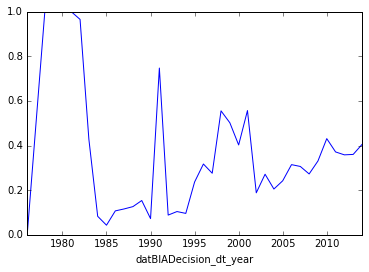

In [36]:
appeals_with_judge['datBIADecision_dt_year'] = appeals_with_judge['datBIADecision_dt'].dt.year 
last_year_grant_rate = appeals_with_judge.groupby('datBIADecision_dt_year')['granted'].mean()
last_year_grant_rate = pd.DataFrame(last_year_grant_rate).rename(columns={'granted': 'last_year_grant_rate'})
last_year_grant_rate['last_year_grant_rate'].plot()

In [37]:
# join to df 
appeals_with_judge['datAppealFiled_dt_year_before'] = appeals_with_judge['datAppealFiled_dt'].dt.year - 1 
appeals_with_last_year = appeals_with_judge.merge(last_year_grant_rate, how='left', 
                                                  left_on='datAppealFiled_dt_year_before', right_index=True)

### Preceeding Year Appeal Grant Rate - Segmented by Feature

In [38]:
# helper methods for Bayesian adjustment 

def calibrate_beta_priors(prior_mean, effective_sample_size): 
    """
    Takes aggregate rate and return Beta priors (alpha, beta) with prior mean approximating aggregate rate
    with respect to effective sample size chosen 
    """
    
    rounded_rate = np.round(prior_mean, 1)
    alpha = int(rounded_rate * effective_sample_size) 
    beta = effective_sample_size - alpha 
    
    return alpha, beta

def compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total): 
    """ 
    Takes Beta priors (alpha, beta) along with observed data (num_total, num_positives) 
    and returns posterior mean 
    """
    
    updated_alpha = alpha_prior + num_positives 
    updated_beta = beta_prior + num_total - num_positives 
    
    posterior_mean = float(updated_alpha) / (updated_alpha + updated_beta)
    
    return posterior_mean 

def compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total): 
    """ 
    Takes Beta priors (alpha, beta) along with observed data (num_total, num_positives) 
    and returns posterior mean 
    """
    
    updated_alpha = alpha_prior + num_positives 
    updated_beta = beta_prior + num_total - num_positives 
    
    posterior_mean = float(updated_alpha) / (updated_alpha + updated_beta)
    
    return posterior_mean

def get_beta_adj_rate(prior_mean, num_positives, num_total, prior_effective_size=10): 
    """ 
    Takes aggregate mean as a float (from 0 to 1), num_total (integer), and num_positives (integer) 
    and return the 'Beta-adjusted' rate. 
    Example: if in total 30% of Chinese nationality cases were granted, and a specific judge saw 20 cases 
    and granted 14 of them, input aggregate_mean=0.3, num_total=20, and num_positives=14 
    """
    
    if type(prior_mean) is not float: 
        raise ValueError("Please enter a float for prior mean!")
        
    if prior_mean < 0 or prior_mean > 1: 
        raise ValueError("Prior mean must be between 0 and 1!")
            
    alpha_prior, beta_prior = calibrate_beta_priors(prior_mean, prior_effective_size)
    posterior_mean = compute_posterior_mean(alpha_prior, beta_prior, num_positives, num_total)
    
    return posterior_mean

In [39]:
get_beta_adj_rate(prior_mean=.3, num_positives=14, num_total=20, prior_effective_size=0)

0.7

#### By Judge in Preceeding Year 

In [40]:
def last_year_grant_rate_by_feature(data, feature, last_year_grant_rate, prior_effective_size=10):
    df = data.groupby([feature, 'datBIADecision_dt_year', 'granted'])\
             .size().unstack().fillna(0).reset_index()\
             .rename(columns={0:'not_granted', 1:'granted'})
    df = df.merge(last_year_grant_rate, how='left', left_on='datBIADecision_dt_year', right_index=True)\
           .rename(columns={'datBIADecision_dt_year': 'datBIADecision_dt_year_'}) 
    new_feature_name = 'last_year_adj_grant_rate_by_{}'.format(feature)
    df[new_feature_name] = df.apply(
        lambda r: get_beta_adj_rate(r['last_year_grant_rate'], r['granted'], 
                                    r['granted'] + r['not_granted'], prior_effective_size), axis=1)
    results = data.merge(df[['datBIADecision_dt_year_', feature, new_feature_name]], how='left', 
                         left_on = ['datAppealFiled_dt_year_before', feature],
                         right_on = ['datBIADecision_dt_year_', feature])\
                  .drop('datBIADecision_dt_year_', axis=1)  
                    
    return results 

In [41]:
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'ij_code', last_year_grant_rate,
                                                         prior_effective_size=0)

In [42]:
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'nat_string', last_year_grant_rate,
                                                         prior_effective_size=0)

In [43]:
appeals_with_last_year['ij_code_nat'] = appeals_with_last_year['ij_code'] + '_' + appeals_with_last_year['nat_string']
appeals_with_last_year = last_year_grant_rate_by_feature(appeals_with_last_year, 'ij_code_nat', last_year_grant_rate,
                                                         prior_effective_size=0)

In [44]:
fp = os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-11-v2.csv') 
appeals_with_last_year.to_csv(fp, index=False)

In [109]:
appeals_with_last_year[pd.isnull(appeals_with_last_year['last_year_adj_grant_rate_by_ij_code_nat'])]['ij_code_nat'].value_counts()

JDD_NICARAGUA                                     267
BMB_EL SALVADOR                                   219
RJD_EL SALVADOR                                   213
JO_CHINA                                          191
TF_EL SALVADOR                                    188
CRH_HAITI                                         187
IS_NICARAGUA                                      173
KC_HAITI                                          161
GDV_HAITI                                         128
KJ_POLAND                                         114
WS_EL SALVADOR                                    114
GDB_EL SALVADOR                                   110
SK_EL SALVADOR                                    103
DWC_HAITI                                         101
JS_EL SALVADOR                                    101
WCP_CHINA                                          99
AO_CHINA                                           97
WAC_CHINA                                          96
FJL_EL SALVADOR             

#### By Judge in Preceding Month 

In [70]:
appeals_with_last_year['']

,Unnamed: 0,idnAppeal,idncase,idnProceeding,strAppealCategory,strAppealType,datAppealFiled,strFiledBy,datAttorneyE27,datBIADecision,...,judge_missing_bio,years_since_appointed,years_since_law_school,datBIADecision_dt_year,datBIADecision_dt_preceeding_year,last_year_grant_rate,last_year_adj_grant_rate_by_ij_code,last_year_adj_grant_rate_by_nat_string,ij_code_nat,last_year_adj_grant_rate_by_ij_code_nat
0,0,4657002,2046931,3200059,IJ,MTR BIA,2004-10-21 00:00:00,A,2004-10-21 00:00:00,2004-12-17 00:00:00,...,0,19.0,29.0,2004,2003,0.271777,0.293478,0.293478,CMZ_CHINA,0.293478
1,1,4693339,2046932,3371117,IJ,Case Appeal,2005-06-10 00:00:00,A,NaN,2006-10-31 00:00:00,...,0,10.0,30.0,2006,2005,0.242399,0.341463,0.341463,EAL_CHINA,0.341463
2,2,4800348,2046933,3200063,IJ,Case Appeal,2007-09-13 00:00:00,A,2007-09-13 00:00:00,2009-06-18 00:00:00,...,0,14.0,44.0,2009,2008,0.273044,0.444444,0.444444,WI_CHINA,0.444444
3,3,4949469,2046935,3200067,IJ,MTR BIA,2011-06-13 00:00:00,A,2011-06-13 00:00:00,2011-07-28 00:00:00,...,0,19.0,29.0,2011,2010,0.431297,0.584906,0.584906,CMZ_CHINA,0.584906
4,4,4963769,2046936,3200068,IJ,MTR BIA,2011-10-26 00:00:00,A,2011-10-26 00:00:00,2011-11-30 00:00:00,...,0,6.0,21.0,2011,2010,0.431297,0.319328,0.319328,AO_CHINA,0.319328


In [69]:
fp = os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-09-v5.csv') 
appeals_with_last_year.to_csv(fp, index=False)

### Average Decision from Preceeding Appeals 

In [12]:
def break_into_chunks(data, dimension, max_chunk): 
    """ Returns a dictionary of lists to instruct breaking up dataset into suitable chunks, 
        where resulting rows from self-join on ij_code does not exceed max_df_rows """
    dimensions = pd.DataFrame(data.groupby(dimension).size().sort_values(ascending=False)) 
    dimensions = dimensions.rename(columns={0: 'rows'}).reset_index() 
    dimensions['self_join'] = dimensions['rows'] ** 2
    dimensions['self_join_cumulative'] = dimensions['self_join'].cumsum() 
    dimensions['chunk'] = np.floor(dimensions['self_join_cumulative'] / max_chunk).astype(int)
    chunk_assignments = dimensions.groupby('chunk')[dimension].apply(list).to_dict()
    print("Split {} labels in {} dimension into {} chunks...".format(len(dimensions), dimension, 
                                                                                  len(chunk_assignments)))
    return chunk_assignments

def compute_last_n_decisions_by_chunk(data_chunk, ref_chunk, dimension, last_n): 
    """ Run compute for a given chunk of data """
    df = data_chunk.merge(ref_chunk, how='left', on=dimension)
    results = df[df['datBIADecision_dt'] < df['datAppealFiled_dt']].groupby('idnAppeal').apply(
        lambda f: f.head(last_n)['granted'].mean()) 
    return results 

def compute_last_n_decisions(data, dimension, max_chunk=50000000, last_n=10): 
    """ Unified method to compute last n decisions """
    
    # get chunk assignments 
    chunk_assignments = break_into_chunks(data, dimension, max_chunk)
    
    # initialize empty list 
    results = [] 
    start = time.time() 
    
    # loop through each chunk 
    for chunk, selected in chunk_assignments.iteritems(): 
        start_chunk = time.time() 
        data_variables = ['idnAppeal', 'datAppealFiled_dt'] + [dimension]
        ref_variables = ['datBIADecision_dt', 'granted'] + [dimension] 
        data_chunk = data[data[dimension].isin(selected)][data_variables]
        ref_chunk = data[data[dimension].isin(selected)][ref_variables].sort_values(
            by=[dimension] + ['datBIADecision_dt'], ascending=[True, False])  
        result = compute_last_n_decisions_by_chunk(data_chunk, ref_chunk, dimension, last_n)
        results.append(result)
        print("Chunk {} completed in {} seconds".format(chunk, time.time() - start_chunk))
        
    print("DONE: Last {} decisions computed for {} dimension in {} seconds".format(last_n, dimension, 
                                                                             time.time() - start))
    return pd.concat(results) 

In [9]:
appeals_with_judge['ij_code_nat'] = appeals_with_judge['ij_code'] + '_' + appeals_with_judge['nat_string']
input_df = appeals_with_judge[['idnAppeal', 'datAppealFiled_dt', 'datBIADecision_dt', 'granted', 
                               'ij_code', 'nat_string', 'ij_code_nat']].copy()

In [15]:
# last 10 appeal grant rate by judge 
last_10_appeal_grant_by_judge = compute_last_n_decisions(input_df, 'ij_code', max_chunk=50000000, last_n=10)

Split 421 labels in ij_code dimension into 7 chunks...
Chunk 0 completed in 19.2041389942 seconds
Chunk 1 completed in 28.5545909405 seconds
Chunk 2 completed in 25.0906300545 seconds
Chunk 3 completed in 23.9727249146 seconds
Chunk 4 completed in 24.8628869057 seconds
Chunk 5 completed in 30.4491810799 seconds
Chunk 6 completed in 14.0754001141 seconds
DONE: Last 10 decisions computed for ij_code dimension in 166.210375071 seconds


In [ ]:
# last 10 appeal grant rate by nationality (this might cause memory issues because the biggest nationality exceeds max_chunk)
last_10_appeal_grant_by_nat = compute_last_n_decisions(input_df, 'nat_string', max_chunk=50000000, last_n=10)

Split 217 labels in nat_string dimension into 12 chunks...
Chunk 67 completed in 131.19086194 seconds
Chunk 69 completed in 53.5213148594 seconds
Chunk 71 completed in 39.8995580673 seconds
Chunk 72 completed in 15.9405970573 seconds
Chunk 73 completed in 27.2509388924 seconds
Chunk 74 completed in 24.8622629642 seconds
Chunk 75 completed in 23.8523321152 seconds
Chunk 76 completed in 26.6039559841 seconds


In [ ]:
# last 10 appeal grant rate by nationality (this might cause memory issues because the biggest nationality exceeds max_chunk)
last_10_appeal_grant_by_nat = compute_last_n_decisions(appeals_with_judge, 'nat_string', max_chunk=50000000, last_n=10)

Split 217 labels in nat_string dimension into 12 chunks...
Chunk 67 completed in 131.932816029 seconds
Chunk 69 completed in 49.9170689583 seconds
Chunk 71 completed in 32.7038171291 seconds
Chunk 72 completed in 16.851774931 seconds
Chunk 73 completed in 31.0073430538 seconds
Chunk 74 completed in 27.637750864 seconds
Chunk 75 completed in 26.6605019569 seconds
Chunk 76 completed in 36.9059078693 seconds


In [ ]:
# last 10 appeal grant rate by judge-nationality 
appeals_add['ij_code_nat'] = appeals_add['ij_code'] + '_' + appeals_add['nat_string']
last_10_appeal_grant_by_judge_nat = compute_last_n_decisions(appeals_add, 'ij_code_nat', max_chunk=50000000, last_n=10)

In [ ]:
appeals_add.merge(last_10_appeal_grant_by_judge, how='left', left_on='idnAppeal', right_index=True)

# OLD 

#### Output dataset for model training

In [129]:
# define mandatory features, without which data will be dropped 
mandatory_features = ['idnAppeal', 'granted', 'datAppealFiled_year', 'case_type_string'] 
appeals_with_master.dropna(subset=mandatory_features, inplace=True)

In [133]:
# save data with all features 
appeals_with_master.to_csv('data_all_features_2018-05-03.csv')

In [134]:
# define features to output for training 
output_features = ['idnAppeal', 'nat_string', 'strCustody', 'strProbono', 'case_type_string',
                   'ij_code', 'lawyer', 'defensive', 'affirmative', 'oral', 'written', 
                   'comp_year', 'osc_year', 'input_year', 'datAppealFiled_year', 'granted']
appeals_final = appeals_with_master[output_features].copy()

# generate output 
appeals_final.to_csv('data_for_model_2018-05-03.csv', index=False)

In [4]:
# reload 
appeals_with_master = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/data_all_features_2018-05-03.csv'), low_memory=False)
appeals_with_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247280 entries, 0 to 247279
Data columns (total 72 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

# Add Judge Variables 

In [12]:
judge_bio = pd.read_csv(os.path.join(DATAFOLDER, 'data/AsylumAdj/data/cleaned_judge_bios.csv')) 
judge_bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Male_judge               367 non-null float64
Year_Appointed_SLR       367 non-null float64
Year_College_SLR         367 non-null float64
Year_Law_school_SLR      367 non-null float64
Government_Years_SLR     367 non-null float64
Govt_nonINS_SLR          367 non-null float64
INS_Years_SLR            367 non-null float64
Military_Years_SLR       367 non-null float64
NGO_Years_SLR            367 non-null float64
Privateprac_Years_SLR    367 non-null float64
Academia_Years_SLR       367 non-null float64
ij_code                  367 non-null object
dtypes: float64(11), object(1)
memory usage: 34.5+ KB


In [9]:
appeals_with_judge = appeals_with_master.merge(judge_bio, how='left', on='ij_code')
appeals_with_judge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 0 to 247279
Data columns (total 83 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [13]:
appeals_with_judge['judge_missing_bio'] = np.where(pd.isnull(appeals_with_judge['Male_judge']), 1, 0) 
appeals_with_judge['judge_missing_bio'].value_counts()

0    230908
1     16372
Name: judge_missing_bio, dtype: int64

In [14]:
# define features to output for training 
output_features = ['idnAppeal', 'nat_string', 'strCustody', 'strProbono', 'case_type_string',
                   'ij_code', 'lawyer', 'defensive', 'affirmative', 'oral', 'written', 
                   'comp_year', 'osc_year', 'input_year', 'datAppealFiled_year', 'granted', 
                   'Male_judge', 'Year_Appointed_SLR', 'Year_College_SLR', 'Year_Law_school_SLR', 
                   'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 'Military_Years_SLR', 
                   'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR', 'judge_missing_bio']

# generate output 
fp = os.path.join(DATAFOLDER, 'data_for_model/data_for_model_with_judge_2018-05-07.csv')
appeals_with_judge[output_features].to_csv(fp, index=False)

# Add Time-Sensitive Variables

#### Years Elapsed Between Judge Appointment and Original Proceeding 

In [23]:
# add years elapsed between judge appointment and original proceeding decision as a variable 
appeals_with_trends = appeals_with_judge.copy()
appeals_with_trends['year_since_appointment'] = appeals_with_trends['comp_year'] - appeals_with_trends['Year_Appointed_SLR']
appeals_with_trends['year_since_appointment'] = np.where(appeals_with_trends['year_since_appointment'] < 0, 
                                                         -1, appeals_with_trends['year_since_appointment']) 
appeals_with_trends['year_since_appointment'].fillna(-1, inplace=True)

#### Last N Decisions (along a given feature) 

In [28]:
# reload - subset for test 
fp = os.path.join(DATAFOLDER, 'data_for_model/data_with_trends_all_features_2018-05-08_v2.csv')
appeals_with_trends = pd.read_csv(fp)
# test_judges = appeals_with_trends['ij_code'].value_counts()[:20].index.tolist()
# appeals_with_trends = appeals_with_trends[appeals_with_trends['ij_code'].isin(test_judges)].copy()
appeals_with_trends['datAppealFiled_dt'] = pd.to_datetime(appeals_with_trends['datAppealFiled_dt'])
appeals_with_trends['datBIADecision_dt'] = pd.to_datetime(appeals_with_trends['datBIADecision_dt'])
appeals_with_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247280 entries, 0 to 247279
Data columns (total 87 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [31]:
appeals_with_trends[appeals_with_trends['idnAppeal'].isin([4524671, 4337953, 4727280, 5035292, 4574639])][['idnAppeal', 'judge_last_10_decisions']]

# 4524671    0.2
# 4337953    0.5
# 4727280    0.3
# 5035292    0.5
# 4574639    0.2

,idnAppeal,judge_last_10_decisions
95775,4337953,0.5
150260,4574639,0.1
157449,4524671,0.2
165428,5035292,0.5
173526,4727280,0.3


In [24]:
ref = appeals_with_trends[['idnAppeal', 'ij_code', 'datBIADecision_dt', 'granted']].copy() 
ref = ref.sort_values(by=['ij_code', 'datBIADecision_dt'], ascending=[True, False])
data = appeals_with_trends[['idnAppeal', 'ij_code', 'datAppealFiled_dt']].copy()

In [25]:
# use multiprocessing to generate average grant rate of last n appeals with the same feature 

from multiprocessing import Pool
from functools import partial 

def apply_func_to_row(row, feature, last_n): 
    """ Creates function to be applied to a dataframe row. Normally we would do df.apply(func, axis=1) 
        but this proves too slow for our purpose. """
    return ref[(ref['ij_code'] == row[feature]) & 
               (ref['datBIADecision_dt'] < row['datAppealFiled_dt'])]['granted'].head(last_n).mean() 

def apply_func_to_data(data, row_func):
    """ Applies function to a (subset of) data and returns ()'idnAppeal', 'judge_last_10_decisions') as a df"""
    data['judge_last_10_decisions'] = data.apply(row_func, axis=1) 
    return data[['idnAppeal', 'judge_last_10_decisions']] 

def parallelize_dataframe(df, func):
    """ Splits data and runs above func in parallel, then combines results to return as a single df """
    df_split = np.array_split(df, 8)
    pool = Pool(4)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def get_recent_decisions(df, feature, last_n): 
    """ Ties above helper methods to get average grant rate of last n appeals that share same feature """
    row_func = partial(apply_func_to_row, feature=feature, last_n=last_n)
    data_func = partial(apply_func_to_data, row_func=row_func) 
    recent_decisions = parallelize_dataframe(df, data_func)
    return recent_decisions 

In [26]:
start_time = time.time()
judge_last_10_decisions_v2 = get_recent_decisions(data, 'ij_code', 10)
print("Computed judge_last_10_decisions in {} seconds".format(time.time() - start_time))

Computed judge_last_10_decisions in 145.61839509 seconds


In [27]:
start_time = time.time()
judge_last_10_decisions_v2 = data.apply(partial(apply_func_to_row, feature='ij_code', last_n=10), axis=1)
print("Computed judge_last_10_decisions in {} seconds".format(time.time() - start_time))

Computed judge_last_10_decisions in 276.233817816 seconds


In [ ]:
start_time = time.time()
data.merge(data, on='ij_code', )
print("Computed judge_last_10_decisions in {} seconds".format(time.time() - start_time))

In [ ]:
start_time = time.time()
judge_last_10_decisions = get_recent_decisions(data, 'ij_code', 10)
print("Computed judge_last_10_decisions in {} seconds".format(time.time() - start_time))

Computed judge_last_10_decisions in 11047.8273649 seconds


In [26]:

appeals_with_trends['ij_code_nat'] = appeals_with_trends['ij_code'] + '_' + appeals_with_trends['nat_string']

In [ ]:
start_time = time.time()
nat_last_10_decisions = get_recent_decisions(data, 'nat_string', 10)
print("Computed nat_string_last_10_decisions in {} seconds".format(time.time() - start_time))

Process PoolWorker-11:
Traceback (most recent call last):
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-10:
    self._target(*self._args, **self._kwargs)
Process PoolWorker-9:
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/pool.py", line 113, in worker
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-12:
Traceback (most recent call last):
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    result = (True, func(*args, **kwds))
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/Users/Gary/anaconda/lib/python2.7/multiprocessing/p

In [ ]:
start_time = time.time()
ij_code_nat_last_10_decisions = get_recent_decisions(data, 'ij_code_nat', 10)
print("Computed ij_code_nat_last_10_decisions in {} seconds".format(time.time() - start_time))

### OLD 

In [5]:
def get_recent_decisions(df, feature, feature_value, dt, last_n=10): 
    subset = df[(df[feature] == feature_value) & (df['datBIADecision_dt'] < dt)]
#     subset = subset.sort_values(by='datBIADecision_dt', ascending=False)
    last_n_grant_rate = subset.head(last_n)['granted'].mean()
    return last_n_grant_rate

In [49]:
appeals_with_trends.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 0 to 247279
Data columns (total 85 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [50]:
appeals_with_trends['judge_last_10_decisions'] = appeals_with_trends.apply(
    lambda x: get_recent_decisions(appeals_with_trends, 'ij_code', x['ij_code'], x['datAppealFiled_dt']), axis=1)

In [3]:
appeals_with_trends = pd.read_csv(os.path.join(DATAFOLDER, 
                                               'data_for_model/data_with_trends_all_features_2018-05-08.csv'))
appeals_with_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247280 entries, 0 to 247279
Data columns (total 86 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [6]:
appeals_with_trends['nat_last_10_decisions'] = appeals_with_trends.apply(
    lambda x: get_recent_decisions(appeals_with_trends, 'nat_string', x['nat_string'], x['datAppealFiled_dt']), axis=1)

In [ ]:
# faster self with self joins 
appeals_with_trends 


In [ ]:
appeals_with_trends['judge_nat_last_10_decisions'] = appeals_with_trends.apply(
    lambda x: get_recent_decisions(appeals_with_trends, 'judge_nat', x['judge_nat'], x['datAppealFiled_dt']), axis=1)

In [7]:
appeals_with_trends.to_csv(os.path.join(DATAFOLDER, 'data_for_model/data_with_trends_all_features_2018-05-08_v2.csv'), 
                           index=False)

In [8]:
# define features to output for training 
output_features = ['idnAppeal', 'nat_string', 'strCustody', 'strProbono', 'case_type_string',
                   'ij_code', 'lawyer', 'defensive', 'affirmative', 'oral', 'written', 
                   'comp_year', 'osc_year', 'input_year', 'datAppealFiled_year', 'granted', 
                   'Male_judge', 'Year_Appointed_SLR', 'Year_College_SLR', 'Year_Law_school_SLR', 
                   'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 'Military_Years_SLR', 
                   'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR', 'judge_missing_bio',
                   'year_since_appointment', 'judge_last_10_decisions', 'nat_last_10_decisions']

# generate output 
fp = os.path.join(DATAFOLDER, 'data_for_model/data_for_model_with_trends_2018-05-08_v2.csv')
appeals_with_trends[output_features].to_csv(fp, index=False)

In [9]:
appeals_with_trends = pd.read_csv(os.path.join(DATAFOLDER, 
                                               'data_for_model/data_with_trends_all_features_2018-05-08_v2.csv')) 
appeals_with_trends['datAppealFiled_dt'] = pd.to_datetime(appeals_with_trends['datAppealFiled_dt'])
appeals_with_trends['datBIADecision_dt'] = pd.to_datetime(appeals_with_trends['datBIADecision_dt'])
appeals_with_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247280 entries, 0 to 247279
Data columns (total 87 columns):
Unnamed: 0                     247280 non-null int64
idnAppeal                      247280 non-null int64
idncase                        247280 non-null int64
idnProceeding                  247280 non-null int64
strAppealCategory              247280 non-null object
strAppealType                  247280 non-null object
datAppealFiled                 247280 non-null object
strFiledBy                     247275 non-null object
datAttorneyE27                 174277 non-null object
datBIADecision                 247280 non-null object
strBIADecision                 247280 non-null object
strBIADecisionType             241077 non-null object
strCaseType                    247278 non-null object
strLang                        246948 non-null object
strNat                         247159 non-null object
strProceedingIHP               121163 non-null object
strCustody                   

In [14]:
judge_trends = appeals_with_trends[['idnAppeal', 'ij_code', 'datAppealFiled_dt', 'datBIADecision_dt', 'granted']].copy()
judge_trends = judge_trends.sort_values(by=['ij_code', 'datBIADecision_dt'], ascending=[True, False])
judge_trends.head()

,idnAppeal,ij_code,datAppealFiled_dt,datBIADecision_dt,granted
55782,5033802,AA,2013-11-07,2014-01-13,1
237862,5010728,AA,2013-03-11,2013-12-23,1
90691,5033444,AA,2013-11-04,2013-12-19,1
235004,5028198,AA,2013-09-03,2013-10-10,0
55783,5003260,AA,2012-12-11,2013-01-31,1


In [17]:
start_time = time.time()
judge_trends['judge_last_10_decisions'] = judge_trends.apply(
    lambda x: get_recent_decisions(judge_trends, 'ij_code', x['ij_code'], x['datAppealFiled_dt']), axis=1)
print('Computed judge last 10 decisions in {} seconds'.format(time.time() - start_time))

Computed judge last 10 decisions in 5535.63796091 seconds


#### Prior Appeal Outcomes for Same Judge (Last 10)  

#### Prior Appeal Outcomes for Same Nationality (Last 10) 

#### Prior Appeal Outcomes for Same Judge Same Nationality 